In [75]:
# Import libraries

# To write a Python 2/3 compatible codebase, the first step is to add this line to the top of each module
from __future__ import division, print_function, unicode_literals

import pandas as pd
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#import pandas_profiling
import os, sys

import datetime

import numpy

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import MinMaxScaler

import gc

gc.collect()
gc.collect()

0

In [3]:
# set # of columns and rows to display

pd.set_option('max_columns', None)
pd.set_option('max_rows', 100)

In [4]:
# Import transaction table

transactions = pd.read_csv('transaction_table.csv')

transactions.head()

,cust_id,tran_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
0,139662,2.017110e+18,2017-11-03,584,145519008,CT,2.89,4.0,0.00,0,2.89,0.7225
1,799924,2.017111e+18,2017-11-12,349,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225
2,1399898,2.017102e+18,2017-10-21,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225
3,1399898,2.017111e+18,2017-11-11,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225
4,1399898,2.017121e+18,2017-12-05,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225


In [5]:
# Transactions shape

transactions.shape

(29617585, 12)

In [6]:
# Transactions data types

transactions.dtypes

cust_id                     int64
tran_id                   float64
tran_dt                    object
store_id                    int64
prod_id                     int64
prod_unit                  object
tran_prod_sale_amt        float64
tran_prod_sale_qty        float64
tran_prod_discount_amt    float64
tran_prod_offer_cts         int64
tran_prod_paid_amt        float64
prod_unit_price           float64
dtype: object

In [7]:
# Transactions descriptive statistics

transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
cust_id,29617585.0,5.016900e+07,2.904564e+07,2.956800e+04,2.500986e+07,5.025960e+07,7.568990e+07,9.999978e+07
tran_id,29617585.0,2.016584e+18,4.993258e+14,2.016010e+18,2.016072e+18,2.017011e+18,2.017070e+18,2.017123e+18
store_id,29617585.0,4.457788e+02,2.004097e+02,1.020000e+02,2.940000e+02,3.930000e+02,5.880000e+02,9.990000e+02
prod_id,29617585.0,9.797496e+08,1.192139e+08,1.455190e+08,9.992470e+08,9.993624e+08,9.996799e+08,9.999997e+08
tran_prod_sale_amt,29617585.0,2.503286e+00,4.130594e+00,1.000000e-02,9.000000e-01,1.590000e+00,2.790000e+00,3.371250e+03
tran_prod_sale_qty,29617585.0,1.667866e+00,2.279535e+00,1.000000e-03,1.000000e+00,1.000000e+00,2.000000e+00,2.112000e+03
tran_prod_discount_amt,29617585.0,-4.027838e-01,1.558037e+00,-1.400250e+03,-2.400000e-01,0.000000e+00,0.000000e+00,0.000000e+00
tran_prod_offer_cts,29617585.0,3.408940e-01,5.339727e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.600000e+01
tran_prod_paid_amt,29617585.0,2.100502e+00,3.162718e+00,-1.410000e+00,8.400000e-01,1.370000e+00,2.320000e+00,1.971000e+03
prod_unit_price,29617585.0,2.093038e+00,2.587080e+00,7.500000e-03,7.400000e-01,1.390000e+00,2.490000e+00,3.990000e+02


In [8]:
# Is there any amount paid for the product (after discounts) less than 0 ?

(transactions['tran_prod_paid_amt'] < 0).any()

True

In [9]:
# Filter out transactions less than 0

transactions.drop(transactions[transactions['tran_prod_paid_amt'] < 0].index, inplace = True)

In [10]:
# Checking potential errors in number of discounts

transactions["tran_prod_offer_cts"].value_counts()

0     20364070
1      8451995
2       766077
3        30327
4         4706
5          189
6          156
8           18
7           14
10           8
9            7
12           2
13           2
14           1
16           1
18           1
20           1
30           1
76           1
Name: tran_prod_offer_cts, dtype: int64

In [11]:
# More than 4 offers on the product

(transactions['tran_prod_offer_cts'] > 4).any()

True

In [12]:
# Individually screening whether the high numbers of discounts are error

transactions[transactions['tran_prod_offer_cts'] == 1].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,8.451995e+06,8.451995e+06,8.451995e+06,8.451995e+06,8.451995e+06,8.451995e+06,8.451995e+06,8451995.0,8.451995e+06,8.451995e+06
mean,5.023613e+07,2.016533e+18,4.455133e+02,9.620627e+08,3.279136e+00,1.737134e+00,-1.198136e+00,1.0,2.081000e+00,2.445389e+00
std,2.905973e+07,5.028834e+14,1.994563e+02,1.626511e+08,4.861358e+00,2.271857e+00,2.151179e+00,0.0,3.017969e+00,3.015256e+00
min,2.956800e+04,2.016010e+18,1.370000e+02,1.455190e+08,1.000000e-02,2.000000e-03,-5.850000e+02,1.0,0.000000e+00,4.944444e-02
25%,2.506982e+07,2.016063e+18,3.030000e+02,9.992378e+08,1.290000e+00,1.000000e+00,-1.300000e+00,1.0,8.900000e-01,9.898214e-01
50%,5.038983e+07,2.016121e+18,3.880000e+02,9.993471e+08,2.000000e+00,1.000000e+00,-6.700000e-01,1.0,1.380000e+00,1.690000e+00
75%,7.570960e+07,2.017080e+18,5.880000e+02,9.996497e+08,3.580000e+00,2.000000e+00,-2.900000e-01,1.0,2.240000e+00,2.790000e+00
max,9.999978e+07,2.017123e+18,9.990000e+02,9.999997e+08,1.166100e+03,7.200000e+02,0.000000e+00,1.0,8.640000e+02,3.990000e+02


In [13]:
transactions[transactions['tran_prod_offer_cts'] == 2].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,7.660770e+05,7.660770e+05,766077.000000,7.660770e+05,766077.000000,766077.000000,766077.000000,766077.0,766077.000000,766077.000000
mean,5.008108e+07,2.016622e+18,428.054890,9.530078e+08,4.910995,2.085320,-2.157011,2.0,2.753984,3.189478
std,2.906043e+07,4.977442e+14,182.010254,1.810934e+08,9.139091,4.651372,4.228822,0.0,5.329454,4.602114
min,2.956800e+04,2.016010e+18,137.000000,1.455190e+08,0.020000,0.006000,-559.680000,2.0,0.000000,0.049444
25%,2.452972e+07,2.016100e+18,304.000000,9.992303e+08,1.590000,1.000000,-2.200000,2.0,0.960000,0.990000
50%,5.012994e+07,2.017022e+18,362.000000,9.993094e+08,2.690000,1.000000,-1.100000,2.0,1.560000,1.980000
75%,7.563963e+07,2.017083e+18,575.000000,9.995454e+08,4.990000,2.000000,-0.530000,2.0,2.840000,3.490000
max,9.999978e+07,2.017123e+18,999.000000,9.999992e+08,1314.720000,2112.000000,0.000000,2.0,755.040000,399.000000


In [14]:
transactions[transactions['tran_prod_offer_cts'] == 3].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,3.032700e+04,3.032700e+04,30327.000000,3.032700e+04,30327.000000,30327.000000,30327.000000,30327.0,30327.000000,30327.000000
mean,4.992584e+07,2.016828e+18,415.941933,9.676086e+08,7.889127,2.533450,-3.581054,3.0,4.308073,4.374162
std,2.904563e+07,4.463604e+14,166.616718,1.534534e+08,17.986815,5.685341,7.296938,0.0,11.407751,5.152979
min,2.956800e+04,2.016010e+18,137.000000,1.525760e+08,0.110000,0.060000,-324.800000,3.0,0.000000,0.079000
25%,2.364976e+07,2.016122e+18,310.000000,9.992313e+08,1.990000,1.000000,-3.720000,3.0,1.100000,1.150000
50%,5.003995e+07,2.017082e+18,347.000000,9.993498e+08,3.780000,1.000000,-1.600000,3.0,1.950000,2.190000
75%,7.568495e+07,2.017122e+18,561.000000,9.996265e+08,7.990000,3.000000,-0.740000,3.0,4.090000,5.488982
max,9.999978e+07,2.017123e+18,999.000000,9.999992e+08,674.550000,450.000000,-0.010000,3.0,459.650000,89.900000


In [15]:
transactions[transactions['tran_prod_offer_cts'] == 4].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,4.706000e+03,4.706000e+03,4706.000000,4.706000e+03,4706.000000,4706.000000,4706.000000,4706.0,4706.000000,4706.000000
mean,5.052354e+07,2.016491e+18,425.311305,9.695883e+08,14.002890,4.525606,-6.065852,4.0,7.937038,3.856950
std,2.903737e+07,4.832187e+14,181.413809,1.447050e+08,33.036649,7.659172,13.342729,0.0,20.840821,4.992215
min,3.977400e+04,2.016010e+18,137.000000,1.525760e+08,0.280000,0.166000,-302.940000,4.0,0.000000,0.079000
25%,2.427989e+07,2.016092e+18,303.000000,9.992349e+08,3.160000,2.000000,-5.640000,4.0,1.960000,0.890000
50%,5.076972e+07,2.016113e+18,353.000000,9.993284e+08,5.800000,2.000000,-2.460000,4.0,3.195000,1.990000
75%,7.631957e+07,2.017071e+18,572.000000,9.995469e+08,11.980000,4.000000,-1.020000,4.0,6.780000,3.990404
max,9.995981e+07,2.017123e+18,999.000000,9.999992e+08,484.380000,240.000000,-0.020000,4.0,305.660000,89.900000


In [16]:
transactions[transactions['tran_prod_offer_cts'] == 5].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,1.890000e+02,1.890000e+02,189.000000,1.890000e+02,189.000000,189.000000,189.000000,189.0,189.000000,189.000000
mean,5.064420e+07,2.016588e+18,423.677249,9.738502e+08,38.884656,11.585021,-14.416720,5.0,24.467937,4.007382
std,2.963801e+07,4.932579e+14,158.659969,1.327157e+08,93.161257,44.655027,32.661957,0.0,61.203388,4.468830
min,1.129755e+06,2.016011e+18,150.000000,1.806110e+08,1.160000,0.966000,-175.000000,5.0,0.740000,0.160000
25%,2.741962e+07,2.016093e+18,321.000000,9.992694e+08,3.600000,2.462000,-8.840000,5.0,2.750000,0.600000
50%,5.012994e+07,2.017011e+18,365.000000,9.995324e+08,7.960000,5.000000,-3.670000,5.0,4.270000,1.960000
75%,7.631991e+07,2.017080e+18,557.000000,9.997465e+08,19.670000,7.000000,-0.610000,5.0,11.360000,5.850000
max,9.960000e+07,2.017123e+18,986.000000,9.999869e+08,459.440000,600.000000,-0.250000,5.0,292.220000,19.990000


In [17]:
transactions[transactions['tran_prod_offer_cts'] == 6].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,1.560000e+02,1.560000e+02,156.000000,1.560000e+02,156.000000,156.000000,156.000000,156.0,156.000000,156.000000
mean,4.632069e+07,2.016500e+18,458.493590,9.596576e+08,31.380385,7.491410,-13.626474,6.0,17.753910,5.081309
std,2.756065e+07,4.862197e+14,188.609735,1.721638e+08,68.688221,9.090859,26.264291,0.0,43.715449,5.851404
min,2.997490e+05,2.016010e+18,143.000000,1.527610e+08,0.560000,0.710000,-210.000000,6.0,0.320000,0.160000
25%,2.529998e+07,2.016101e+18,332.750000,9.992287e+08,4.745000,2.027000,-13.200000,6.0,3.300000,0.990000
50%,4.203986e+07,2.016112e+18,475.000000,9.992702e+08,10.765000,4.000000,-5.040000,6.0,5.145000,2.590000
75%,6.440970e+07,2.017071e+18,588.000000,9.996354e+08,30.325000,8.000000,-1.690000,6.0,14.512500,7.065000
max,9.910978e+07,2.017122e+18,996.000000,9.999590e+08,599.400000,60.000000,-0.240000,6.0,389.400000,27.990000


In [18]:
transactions[transactions['tran_prod_offer_cts'] == 7].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,1.400000e+01,1.400000e+01,14.000000,1.400000e+01,14.000000,14.000000,14.00000,14.0,14.000000,14.000000
mean,4.901474e+07,2.016572e+18,425.357143,9.995536e+08,54.418571,11.571429,-19.30500,7.0,35.113571,2.352857
std,3.221396e+07,4.973117e+14,136.200422,2.380817e+05,165.782572,17.028096,55.40039,0.0,110.638242,2.985780
min,1.889991e+06,2.016071e+18,172.000000,9.991630e+08,4.200000,3.000000,-210.00000,7.0,2.170000,0.600000
25%,2.898968e+07,2.016092e+18,339.000000,9.993131e+08,4.867500,4.750000,-6.98000,7.0,3.850000,0.600000
50%,4.584957e+07,2.016567e+18,477.000000,9.997465e+08,5.400000,7.500000,-0.52500,7.0,4.950000,0.600000
75%,7.491737e+07,2.017061e+18,483.000000,9.997465e+08,12.720000,9.750000,-0.41250,7.0,6.327500,2.740000
max,9.099966e+07,2.017072e+18,632.000000,9.997465e+08,629.300000,70.000000,-0.35000,7.0,419.300000,8.990000


In [19]:
transactions[transactions['tran_prod_offer_cts'] == 8].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,1.800000e+01,1.800000e+01,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.0,18.000000,18.000000
mean,4.931308e+07,2.016619e+18,362.222222,9.994552e+08,175.810000,23.684778,-71.935556,8.0,103.874444,7.696692
std,2.651170e+07,5.045657e+14,153.739105,2.233359e+05,215.311102,19.923024,82.892298,0.0,134.312050,7.017227
min,1.989964e+07,2.016012e+18,153.000000,9.991638e+08,4.740000,2.000000,-300.000000,8.0,3.250000,0.600000
25%,2.585724e+07,2.016083e+18,269.000000,9.992392e+08,26.495000,8.500000,-109.917500,8.0,12.125000,1.912498
50%,4.426977e+07,2.017022e+18,330.000000,9.994643e+08,79.420000,22.545500,-45.955000,8.0,35.065000,7.489922
75%,7.145472e+07,2.017063e+18,442.250000,9.996429e+08,280.077500,29.214250,-11.442500,8.0,166.930000,10.990090
max,9.772982e+07,2.017121e+18,679.000000,9.997465e+08,749.250000,75.000000,-0.400000,8.0,449.250000,19.990000


In [20]:
transactions[transactions['tran_prod_offer_cts'] == 9].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,7.000000e+00,7.000000e+00,7.000000,7.000000e+00,7.000000,7.000000,7.000000,7.0,7.000000,7.000000
mean,6.586539e+07,2.016641e+18,465.000000,9.997189e+08,160.477143,27.866000,-61.544286,9.0,98.932857,3.994243
std,3.434289e+07,5.368426e+14,155.926265,2.499824e+05,308.100407,28.969882,108.063784,0.0,200.940107,5.219656
min,7.819901e+06,2.016050e+18,261.000000,9.992392e+08,6.000000,10.000000,-297.500000,9.0,5.500000,0.600000
25%,4.584957e+07,2.016077e+18,373.000000,9.996767e+08,7.200000,10.579000,-62.565000,9.0,6.600000,0.600000
50%,7.190964e+07,2.017061e+18,477.000000,9.997465e+08,17.350000,13.000000,-6.480000,9.0,10.870000,1.090921
75%,9.505472e+07,2.017062e+18,551.500000,9.998517e+08,118.220000,32.952000,-0.600000,9.0,55.655000,6.040000
max,9.951960e+07,2.017100e+18,668.000000,9.999898e+08,849.150000,85.000000,-0.500000,9.0,551.650000,12.988777


In [21]:
transactions[transactions['tran_prod_offer_cts'] == 10].describe()

,cust_id,tran_id,store_id,prod_id,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price
count,8.000000e+00,8.000000e+00,8.000000,8.000000e+00,8.000000,8.000000,8.000000,8.0,8.000000,8.000000
mean,7.003850e+07,2.016576e+18,462.000000,9.997283e+08,327.101250,40.262375,-135.855000,10.0,191.246250,5.032520
std,2.612811e+07,5.365698e+14,170.241006,1.267567e+05,432.868846,38.201864,171.966635,0.0,264.396881,5.493981
min,1.989964e+07,2.016043e+18,261.000000,9.995521e+08,6.000000,10.000000,-450.000000,10.0,5.500000,0.600000
25%,6.539463e+07,2.016083e+18,267.000000,9.996500e+08,6.900000,11.500000,-242.895000,10.0,6.325000,0.600000
50%,7.285980e+07,2.016582e+18,533.500000,9.997465e+08,104.740000,21.549500,-55.940000,10.0,48.800000,2.245000
75%,8.544231e+07,2.017070e+18,607.250000,9.997465e+08,539.822500,62.750000,-0.575000,10.0,296.927500,9.490000
max,9.841998e+07,2.017093e+18,617.000000,9.999887e+08,1099.000000,100.000000,-0.500000,10.0,649.000000,13.990160


In [22]:
# Number of discounts larger than 6 don't seem to make sense

transactions.drop(transactions[transactions['tran_prod_offer_cts'] > 6].index, inplace = True)

In [23]:
# Segment together products with 5 offers with products with 6 offers for clustering later (few instances and similar characteristics)

transactions[transactions['tran_prod_offer_cts'] == 6] = 5

In [24]:
# Check count for offers on product

transactions["tran_prod_offer_cts"].value_counts()

0    20364070
1     8451995
2      766077
3       30327
4        4706
5         345
Name: tran_prod_offer_cts, dtype: int64

In [25]:
# Checking if there are errors in the sales amt

transactions['sale_amt'] = transactions['tran_prod_sale_amt'] + transactions['tran_prod_discount_amt'] - transactions['tran_prod_paid_amt']

sum(round(transactions['sale_amt'],2) != 0)

156

In [26]:
sum(transactions['tran_prod_discount_amt'] != 0)

9251609

In [27]:
# Checking specifics

transactions[round(transactions['sale_amt'],2) != 0].iloc[:,[6,8,10,12]]

,tran_prod_sale_amt,tran_prod_discount_amt,tran_prod_paid_amt,sale_amt
14696,5.0,5.0,5.0,5.0
194586,5.0,5.0,5.0,5.0
200738,5.0,5.0,5.0,5.0
204652,5.0,5.0,5.0,5.0
299034,5.0,5.0,5.0,5.0
...,...,...,...,...
26802764,5.0,5.0,5.0,5.0
27321755,5.0,5.0,5.0,5.0
27444231,5.0,5.0,5.0,5.0
28180741,5.0,5.0,5.0,5.0


In [28]:
# removing those rows

transactions.drop(transactions[round(transactions['sale_amt'],2) != 0].index, inplace = True)

In [29]:
sum(round(transactions['sale_amt'],2) != 0)

0

In [30]:
# Drop the tempory column

transactions.drop("sale_amt", axis=1, inplace = True)

In [31]:
# Checking how many unique transaction IDs

transactions['tran_id'].nunique()

753

In [33]:
# Fixing number of transaction IDs by assuming if a customer has > 1 transactions on the same day 
# in the same store it was the same transaction

transactions['tran_id'] = transactions['cust_id'].astype('str').str.cat([transactions['tran_dt'], transactions['store_id'].astype('str')], sep="_") 

In [35]:
# Checking unique number of New Transaction IDs

transactions['tran_id'].nunique()

2830549

In [36]:
# Converting transaction date from object to date 

transactions['tran_dt'] = pd.to_datetime(transactions['tran_dt'])

In [38]:
# Creating day of the week column

transactions['weekday'] = transactions['tran_dt'].dt.day_name()

In [39]:
# Creating month column 

transactions['month'] = transactions['tran_dt'].dt.month

In [40]:
# Creating year column

transactions['year'] = transactions['tran_dt'].dt.year

In [41]:
# Checking for NAs

transactions.isna().sum()

cust_id                   0
tran_id                   0
tran_dt                   0
store_id                  0
prod_id                   0
prod_unit                 0
tran_prod_sale_amt        0
tran_prod_sale_qty        0
tran_prod_discount_amt    0
tran_prod_offer_cts       0
tran_prod_paid_amt        0
prod_unit_price           0
weekday                   0
month                     0
year                      0
dtype: int64

In [42]:
# Import products table

products = pd.read_csv('product_table.csv')

products.head()

,prod_id,subcategory_id,sub_category_desc,category_id,category_desc,brand_desc,category_desc_eng
0,145519008,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH
1,145519009,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH
2,145519010,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH
3,145519011,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH
4,145519012,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH


In [43]:
# Products shape

products.shape

(10767, 7)

In [44]:
# Products data types

products.dtypes

prod_id               int64
subcategory_id        int64
sub_category_desc    object
category_id           int64
category_desc        object
brand_desc           object
category_desc_eng    object
dtype: object

In [45]:
# Checking for NAs

products.isna().sum()

prod_id              0
subcategory_id       0
sub_category_desc    0
category_id          0
category_desc        0
brand_desc           0
category_desc_eng    0
dtype: int64

In [46]:
# Merging transactions and customers table

transaction_product = transactions.merge(products, how="inner", on="prod_id")

transaction_product.head()

,cust_id,tran_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,weekday,month,year,subcategory_id,sub_category_desc,category_id,category_desc,brand_desc,category_desc_eng
0,139662,139662_2017-11-03_584,2017-11-03,584,145519008,CT,2.89,4.0,0.00,0,2.89,0.7225,Friday,11,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH
1,799924,799924_2017-11-12_349,2017-11-12,349,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225,Sunday,11,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH
2,1399898,1399898_2017-10-21_684,2017-10-21,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225,Saturday,10,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH
3,1399898,1399898_2017-11-11_684,2017-11-11,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225,Saturday,11,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH
4,1399898,1399898_2017-12-05_684,2017-12-05,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225,Tuesday,12,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH


In [47]:
# Checking for NAs

transaction_product.isna().sum()

cust_id                   0
tran_id                   0
tran_dt                   0
store_id                  0
prod_id                   0
prod_unit                 0
tran_prod_sale_amt        0
tran_prod_sale_qty        0
tran_prod_discount_amt    0
tran_prod_offer_cts       0
tran_prod_paid_amt        0
prod_unit_price           0
weekday                   0
month                     0
year                      0
subcategory_id            0
sub_category_desc         0
category_id               0
category_desc             0
brand_desc                0
category_desc_eng         0
dtype: int64

In [51]:
del transactions
del products
gc.collect()

38

In [52]:
# Removing bags

transaction_product = transaction_product[transaction_product["category_desc_eng"] != "BAGS"]

In [53]:
# Setting up variables to calculate profit margin for products with prod_unit = CT

transaction_product["base_unit_price"] = transaction_product["tran_prod_paid_amt"]/transaction_product["tran_prod_sale_qty"]
transaction_product["item_identity"] = transaction_product["store_id"].astype(str) + transaction_product["prod_id"].astype(str)

In [54]:
# Filtering those items

tmp = transaction_product.loc[transaction_product.prod_unit == "CT",["item_identity", "base_unit_price"]]

In [55]:
# Finding min price for each item_store pair

tmp = tmp.groupby("item_identity").agg("min")

In [56]:
# Mapping info back to the main dataframe

tmp = tmp.iloc[:,0]

transaction_product["min_price"] = transaction_product["item_identity"].map(tmp)

In [57]:
# Setting up variables to calculate profit margin, including seasonailty information now

transaction_product.loc[transaction_product.month.isin([12,1,2]),"season"] = "winter"
transaction_product.loc[transaction_product.month.isin([3,4,5]),"season"] = "spring"
transaction_product.loc[transaction_product.month.isin([6,7,8]),"season"] = "summer"
transaction_product.loc[transaction_product.month.isin([9,10,11]),"season"] = "fall"
transaction_product["item_identity"] = transaction_product["store_id"].astype(str) + transaction_product["prod_id"].astype(str) + transaction_product["season"]

In [58]:
# Filtering those items

tmp = transaction_product.loc[transaction_product.prod_unit == "KG",["item_identity", "base_unit_price"]]

In [59]:
# Finding min price for each item_store_month pair

tmp = tmp.groupby("item_identity").agg("min")

In [60]:
# Mapping info back to main dataframe

tmp = tmp.iloc[:,0]

transaction_product["min_price2"] = transaction_product["item_identity"].map(tmp)

In [61]:
# Merging the two columns

transaction_product.loc[transaction_product.min_price.isna(),"min_price"] = transaction_product.loc[transaction_product.min_price.isna(),"min_price2"]

In [62]:
# Dropping the intermediate columns and checking if price is correctly calculated

transaction_product.drop("item_identity", axis=1, inplace = True)
transaction_product.drop("min_price2", axis=1, inplace = True)

transaction_product.isna().sum()

cust_id                   0
tran_id                   0
tran_dt                   0
store_id                  0
prod_id                   0
prod_unit                 0
tran_prod_sale_amt        0
tran_prod_sale_qty        0
tran_prod_discount_amt    0
tran_prod_offer_cts       0
tran_prod_paid_amt        0
prod_unit_price           0
weekday                   0
month                     0
year                      0
subcategory_id            0
sub_category_desc         0
category_id               0
category_desc             0
brand_desc                0
category_desc_eng         0
base_unit_price           0
min_price                 0
season                    0
dtype: int64

In [63]:
# Calculating margin

margin = ((transaction_product["base_unit_price"] - transaction_product["min_price"]) * transaction_product["tran_prod_sale_qty"]).sum()/transaction_product["tran_prod_paid_amt"].sum()

In [64]:
# the margin level makes sense for a retailer of such kind compared to other similar retailers on the market

margin

0.2214321368422946

In [65]:
# Adding margin to dataframe

transaction_product["margin"] = (transaction_product["base_unit_price"] - transaction_product["min_price"]) * transaction_product["tran_prod_sale_qty"]

# Segementation - Store level

In [66]:
# AVERAGE DISCOUNT RATE 

avg_discount_rate = round((transaction_product.groupby('cust_id')['tran_prod_discount_amt'].sum().abs() / (transaction_product.groupby('cust_id')['tran_prod_sale_amt'].sum())).sort_values(ascending=False),4)

avg_discount_rate.sort_values(ascending=False)

cust_id
33259966    0.3738
77329638    0.3718
81779810    0.3494
91759561    0.3471
22179626    0.3401
             ...  
6759926     0.0418
5649867     0.0409
75069811    0.0395
15509934    0.0392
84299926    0.0342
Length: 7920, dtype: float64

In [67]:
# DISCOUNTED PRODUCTS 

discount_count = transaction_product[transaction_product['tran_prod_discount_amt'] != 0].groupby('cust_id')['tran_prod_discount_amt'].count()

discount_count.sort_values(ascending=False)

cust_id
73979986    4074
96339836    3502
13129627    3300
2629968     3157
75709600    3128
            ... 
85429551     118
66869557     117
14359520     112
96879682     111
71909645      72
Name: tran_prod_discount_amt, Length: 7920, dtype: int64

In [68]:
# DISCOUNT FREQUENCY

discount_freq = discount_count / transaction_product.groupby('cust_id')['tran_prod_discount_amt'].count()

discount_freq.sort_values(ascending=False)

cust_id
77329638    0.794456
81779810    0.699308
91759561    0.686454
17299665    0.684938
19899641    0.676471
              ...   
95569587    0.126199
49309956    0.124346
5649867     0.109824
89159772    0.107113
14359520    0.103704
Name: tran_prod_discount_amt, Length: 7920, dtype: float64

In [69]:
# MONTHLY TRANSACTIONS

monthly_tran = transaction_product.groupby('cust_id')['tran_id'].nunique().reset_index()

transaction_product["year_month"] = transaction_product["year"].astype('str') + transaction_product["month"].astype('str')

tmp = transaction_product.groupby('cust_id')['year_month'].nunique()

monthly_tran["month"] = monthly_tran["cust_id"].map(tmp)

monthly_tran["monthly_tran"] = monthly_tran["tran_id"]/monthly_tran["month"]

monthly_tran = monthly_tran.iloc[:,[0,3]]

monthly_tran = monthly_tran.set_index("cust_id").iloc[:,0]

monthly_tran

cust_id
29568       14.000000
29909       16.666667
39774       11.583333
39856       25.000000
59984       15.291667
              ...    
99969716    14.250000
99969769    11.125000
99989975    14.333333
99989987    16.666667
99999776    16.583333
Name: monthly_tran, Length: 7920, dtype: float64

In [70]:
# MONTHLY SPENDING

monthly_spend = transaction_product.groupby('cust_id')['tran_prod_paid_amt'].sum().reset_index()

tmp = transaction_product.groupby('cust_id')['year_month'].nunique()

monthly_spend["month"] = monthly_spend["cust_id"].map(tmp)

monthly_spend["monthly_tran"] = monthly_spend["tran_prod_paid_amt"]/monthly_spend["month"]

monthly_spend = monthly_spend.iloc[:,[0,3]]

monthly_spend = monthly_spend.set_index("cust_id").iloc[:,0]

monthly_spend

cust_id
29568       499.558636
29909       493.196667
39774       369.897500
39856       385.180000
59984       361.963333
               ...    
99969716    314.587917
99969769    251.855417
99989975    251.121667
99989987    355.330000
99999776    275.857500
Name: monthly_tran, Length: 7920, dtype: float64

In [71]:
# MARGIN RATIO

margin_ratio = transaction_product.groupby('cust_id')['margin'].sum().reset_index()

tmp = transaction_product.groupby('cust_id')['tran_prod_paid_amt'].sum()

margin_ratio["paid"] = margin_ratio["cust_id"].map(tmp)

margin_ratio["margin_ratio"] = margin_ratio["margin"]/margin_ratio["paid"]

margin_ratio = margin_ratio.iloc[:,[0,3]]

margin_ratio = margin_ratio.set_index("cust_id").iloc[:,0]

margin_ratio

cust_id
29568       0.284020
29909       0.170569
39774       0.184126
39856       0.207880
59984       0.183403
              ...   
99969716    0.268577
99969769    0.177552
99989975    0.197432
99989987    0.234016
99999776    0.249848
Name: margin_ratio, Length: 7920, dtype: float64

In [72]:
# Creating store dictionary

cust_dict = {'monthly_spend':monthly_spend,'monthly_tran':monthly_tran, 'margin_ratio': margin_ratio, 'avg_discount_rate': avg_discount_rate}

In [73]:
# Creating stores dataframe

customers = pd.DataFrame(data=cust_dict)

In [76]:
# Standardizing the data

scaler = StandardScaler()

customers_scaled = scaler.fit_transform(customers)

In [77]:
# Defining the k-means function with initialization as k-means++
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=1000)

# Fitting the k-means algorithm on scaled data
kmeans.fit(customers_scaled)

KMeans(max_iter=1000, n_clusters=2)

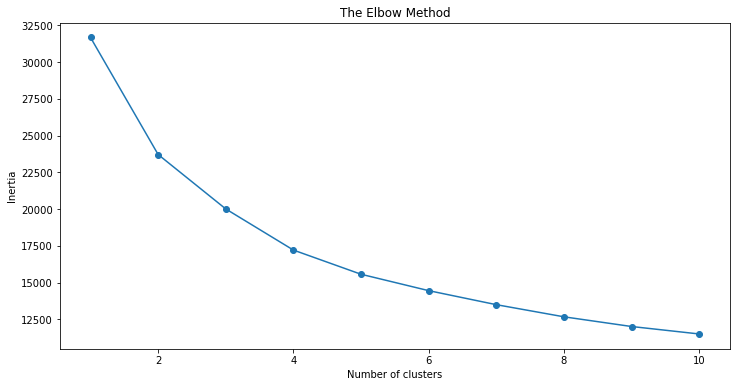

In [78]:
# Fitting multiple k-means algorithms and storing the values in an empty list
SSE = []
for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(customers_scaled)
    SSE.append(kmeans.inertia_)

# Converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,11), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method');

In [79]:
# k means using 4 clusters and k-means++ initialization

kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(customers_scaled)
pred = kmeans.predict(customers_scaled)

In [80]:
# Checking how many customers in each cluster

frame = pd.DataFrame(customers)
frame.columns = customers.columns.values
frame.index = customers.index.values
frame['cluster'] = pred
frame['cluster'].value_counts()

0    2950
2    2201
1    1488
3    1281
Name: cluster, dtype: int64

In [81]:
# Centroids

centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = customers.columns.values[:4]
centroids

,monthly_spend,monthly_tran,margin_ratio,avg_discount_rate
0,-0.554821,-0.390778,-0.696815,0.747844
1,1.405172,-0.215375,0.084706,-0.123640
2,-0.399496,-0.325452,0.734083,-0.701957
3,0.334318,1.709302,0.240633,-0.368189


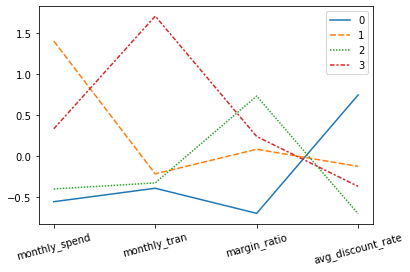

In [82]:
# Plotting results

sns.lineplot(data = centroids.T)
plt.xticks(rotation=15);

In [83]:
frame.groupby('cluster').describe().T

cluster                            0            1            2            3
monthly_spend     count  2950.000000  1488.000000  2201.000000  1281.000000
                  mean    289.564580   464.552124   303.546182   369.048550
                  std      52.011017    71.710747    50.756064    75.352788
                  min     160.779583   355.275833   173.655833   204.535000
                  25%     248.512083   417.087292   263.602500   311.460417
                  50%     283.090208   452.056042   299.201250   364.916250
                  75%     325.635208   494.103646   339.549167   417.647500
                  max     545.569524   977.193571   482.239583   658.473846
monthly_tran      count  2950.000000  1488.000000  2201.000000  1281.000000
                  mean     13.624484    14.399771    13.921439    22.940852
                  std       2.834826     2.944054     2.664862     3.446339
                  min       2.785714     4.400000     5.625000    17.583333
                  25%      11.666667    12.375000    12.041667    20.391304
                  50%      13.291667    14.133929    13.666667    22.291667
                  75%      15.456250    16.541667    15.833333    25.000000
                  max      24.541667    25.928571    21.666667    41.136364
margin_ratio      count  2950.000000  1488.000000  2201.000000  1281.000000
                  mean      0.196047     0.223273     0.246126     0.228740
                  std       0.024516     0.029004     0.032030     0.029039
                  min       0.050918     0.103581     0.163922     0.141629
                  25%       0.180512     0.202974     0.224854     0.207849
                  50%       0.196232     0.223129     0.241674     0.227299
                  75%       0.211789     0.241961     0.262431     0.247078
                  max       0.289843     0.380926     0.463282     0.340775
avg_discount_rate count  2950.000000  1488.000000  2201.000000  1281.000000
                  mean      0.193869     0.154032     0.127571     0.142862
                  std       0.035918     0.039228     0.032663     0.039694
                  min       0.080200     0.034200     0.039500     0.039200
                  25%       0.169500     0.127700     0.104300     0.114700
                  50%       0.191400     0.154700     0.127600     0.140900
                  75%       0.214775     0.181400     0.149600     0.169100
                  max       0.373800     0.312800     0.286500     0.288900

In [84]:
# mapping the clusters back to original dataset

tmp = frame.iloc[:,4]

transaction_product["cluster1"] = transaction_product["cust_id"].map(tmp)

transaction_product.head()

,cust_id,tran_id,tran_dt,store_id,prod_id,prod_unit,tran_prod_sale_amt,tran_prod_sale_qty,tran_prod_discount_amt,tran_prod_offer_cts,tran_prod_paid_amt,prod_unit_price,weekday,month,year,subcategory_id,sub_category_desc,category_id,category_desc,brand_desc,category_desc_eng,base_unit_price,min_price,season,margin,year_month,cluster1
0,139662,139662_2017-11-03_584,2017-11-03,584,145519008,CT,2.89,4.0,0.00,0,2.89,0.7225,Friday,11,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH,0.7225,0.36,fall,1.45,201711,2
1,799924,799924_2017-11-12_349,2017-11-12,349,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225,Sunday,11,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH,0.3600,0.36,fall,0.00,201711,2
2,1399898,1399898_2017-10-21_684,2017-10-21,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225,Saturday,10,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH,0.3600,0.36,fall,0.00,201710,3
3,1399898,1399898_2017-11-11_684,2017-11-11,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225,Saturday,11,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH,0.3600,0.36,fall,0.00,201711,3
4,1399898,1399898_2017-12-05_684,2017-12-05,684,145519008,CT,2.89,4.0,-1.45,1,1.44,0.7225,Tuesday,12,2017,93970,IOGURTE BIFIDUS LIQ,95854,IOGURTE SAUDE,ACTIVIA,YOGURT HEALTH,0.3600,0.36,winter,0.00,201712,3


In [86]:
# transaction_product.to_csv("C:/Users/10331/OneDrive/Desktop/transaction_product.csv", index = False)

# Price Optimization

In [87]:
# transaction_product = pd.read_csv("C:/Users/10331/OneDrive/Desktop/transaction_product.csv")

In [93]:
# get week number

transaction_product['week'] = transaction_product['tran_dt'].dt.isocalendar().week

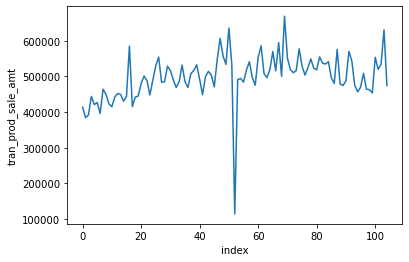

In [111]:
# REVENUE CHANGE OVER TIME for non-fresh goods

tmp = transaction_product.loc[transaction_product.prod_unit == "CT",:].groupby(["year","week"]).agg({"tran_prod_sale_amt":"sum"}).reset_index().reset_index()

sns.lineplot(data=tmp, x="index", y="tran_prod_sale_amt");

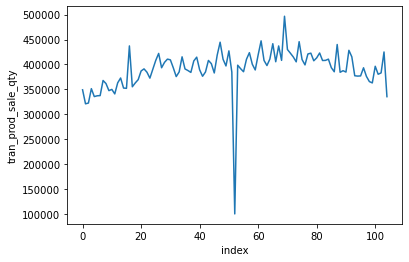

In [112]:
# Sales quantity CHANGE OVER TIME for non-fresh goods

tmp = transaction_product.loc[transaction_product.prod_unit == "CT",:].groupby(["year","week"]).agg({"tran_prod_sale_qty":"sum"}).reset_index().reset_index()

sns.lineplot(data=tmp, x="index", y="tran_prod_sale_qty");

In [90]:
transaction_product.dtypes

cust_id                            int64
tran_id                           object
tran_dt                   datetime64[ns]
store_id                           int64
prod_id                            int64
prod_unit                         object
tran_prod_sale_amt               float64
tran_prod_sale_qty               float64
tran_prod_discount_amt           float64
tran_prod_offer_cts                int64
tran_prod_paid_amt               float64
prod_unit_price                  float64
weekday                           object
month                              int64
year                               int64
subcategory_id                     int64
sub_category_desc                 object
category_id                        int64
category_desc                     object
brand_desc                        object
category_desc_eng                 object
base_unit_price                  float64
min_price                        float64
season                            object
margin          

In [221]:
# check for categories account for most sales

category_list = transaction_product.loc[transaction_product.prod_unit == "CT",:].groupby("category_desc_eng").tran_prod_sale_qty.sum().sort_values(ascending = False)
category_list.head(30)

category_desc_eng
MINERAL WATERS                  2171723.0
PAO MANUFACTURE                 2137167.0
FRESH UHT MILK                  1773972.0
YOGURT HEALTH                   1491111.0
SPECIAL UHT MILK                1317446.0
INDIVIDUAL BOWLS                1188210.0
YOGURT DRINK                    1173629.0
FROZEN BREAD                    1172238.0
ICE TEA                          956966.0
FRUIT JUICES                     881189.0
BEER WITH ALCOHOL                853630.0
FINE WAFERS                      844864.0
YOGURT TRADITIONAL               822203.0
CANNED TUNA                      774938.0
CANNED VEGETABLES                704009.0
ANIMAL FOOD                      654575.0
REGULAR EGGS                     573805.0
BREAD FMF                        570677.0
FINE WINES                       557911.0
RICE                             507126.0
KLEENEX                          506175.0
FRENCH FRIES                     440229.0
YOGURT SPECIALTIES               422889.0
COFFEES AND ROAS

In [222]:
# check for categories sell at most stores

pb = transaction_product.loc[transaction_product.prod_unit == "CT",:].groupby("category_desc_eng").store_id.count().sort_values(ascending = False)
pb.head(30)

category_desc_eng
FINE WAFERS                     663631
MINERAL WATERS                  630926
CANNED VEGETABLES               466806
PAO MANUFACTURE                 438412
YOGURT HEALTH                   408151
FRESH UHT MILK                  403641
ICE TEA                         366182
FRUIT JUICES                    361223
FINE WINES                      333850
FRENCH FRIES                    333025
REGULAR EGGS                    326771
FROZEN BREAD                    323576
BREAKFAST CEREALS               297406
INDIVIDUAL BOWLS                296078
RICE                            293563
COFFEES AND ROASTED MIXTURES    279023
YOGURT DRINK                    272259
CANNED TUNA                     270161
YOGURT SPECIALTIES              261490
ANIMAL FOOD                     248970
SPECIAL UHT MILK                246070
PACKAGED BREAD                  244994
READY TO EAT                    238358
YOGURT TRADITIONAL              226639
SAUSAGES                        222744
FRUIT S

In [223]:
# check for categories sell includes most products

pa = transaction_product.loc[transaction_product.prod_unit == "CT",:].groupby("category_desc_eng").prod_id.count().sort_values(ascending = False)
pa.head(30)

category_desc_eng
FINE WAFERS                     663631
MINERAL WATERS                  630926
CANNED VEGETABLES               466806
PAO MANUFACTURE                 438412
YOGURT HEALTH                   408151
FRESH UHT MILK                  403641
ICE TEA                         366182
FRUIT JUICES                    361223
FINE WINES                      333850
FRENCH FRIES                    333025
REGULAR EGGS                    326771
FROZEN BREAD                    323576
BREAKFAST CEREALS               297406
INDIVIDUAL BOWLS                296078
RICE                            293563
COFFEES AND ROASTED MIXTURES    279023
YOGURT DRINK                    272259
CANNED TUNA                     270161
YOGURT SPECIALTIES              261490
ANIMAL FOOD                     248970
SPECIAL UHT MILK                246070
PACKAGED BREAD                  244994
READY TO EAT                    238358
YOGURT TRADITIONAL              226639
SAUSAGES                        222744
FRUIT S

In [113]:
# check for categories account for most price variance

tmp = transaction_product.loc[transaction_product.prod_unit == "CT",:].groupby("category_desc_eng").prod_unit_price.std().sort_values(ascending = False)
tmp.head(50)

category_desc_eng
FOOD PREPARATION                           45.615368
LCDS AND PLASMAS                           44.782178
COFFEE MACHINES                            25.349999
CLOTHING CARE                              21.638058
KITCHEN STAINLESS STEEL ARTICLES           21.271055
SOIL CONSERVATION AND CLEANING             20.981050
AIR CONDITIONING                           20.125057
COMPRESSORS AND ACCESSORIES                19.723683
MANICURE PEDICURE                          14.358419
OVENS                                      13.802369
LEATHER GOODS                              12.769951
OTHER TOYS                                 11.971841
ALUMINUM KITCHEN ITEMS                     11.402522
GIRL TOYS                                  11.309487
ELECTRIC TOOLS                             10.584274
LUBRICANTS                                 10.274937
MEAT DISHES                                10.128618
PROTECTION & WORK                           9.838610
TEFLON KITCHEN ITEMS        

In [225]:
# Find the intercetion ones 

num = 100
set(category_list.head(num).index)&set(pa.head(num).index)&set(pb.head(num).index)&set(tmp.head(num).index)

{'BEER WITH ALCOHOL',
 'DRY FOOD ANIMALS',
 'FOOD CHILDREN',
 'OLIVE OIL',
 'PREPARED MEAT AND FROZEN FISH',
 'STANDARD WINES',
 'TOILET PAPER',
 'WASHING MACHINE DETERGENTS'}

In [1154]:
category_list = ["BEER WITH ALCOHOL","STANDARD WINES"]

In [1157]:
# find top 100 skus that account for most sales quantity and price variance across the selected 10 stores

num = 128

tmp = transaction_product.loc[(transaction_product.category_desc_eng.isin(category_list)),:].groupby(["prod_id","store_id"]).prod_unit_price.std().reset_index()

prod_list = (set(transaction_product.loc[(transaction_product.category_desc_eng.isin(category_list)),:].groupby("prod_id").tran_prod_sale_qty.sum().sort_values(ascending = False).head(num).index)&
                 set(transaction_product.loc[(transaction_product.category_desc_eng.isin(category_list)),:].groupby("prod_id").prod_unit_price.std().sort_values(ascending = False).head(num).index)&
                 set(transaction_product.loc[(transaction_product.category_desc_eng.isin(category_list)),:].groupby("prod_id").store_id.nunique().sort_values(ascending = False).head(num).index)&
                 set(tmp.loc[tmp.prod_unit_price != 0,:].prod_id.value_counts().sort_values(ascending = False).head(num).index))
print(len(prod_list))

102


In [1158]:
# check for number from each category

transaction_product.loc[transaction_product.prod_id.isin(prod_list),["prod_id","category_desc_eng"]].groupby("category_desc_eng").nunique()

,prod_id
category_desc_eng,
BEER WITH ALCOHOL,63
STANDARD WINES,39


In [267]:
# Selected BEER WITH ALCOHOL and STANDARD WINES, because they have decent sales, price variance, 
# and sell at different stores with decent variations

pa = "BEER WITH ALCOHOL"
pb = "STANDARD WINES"

transaction_product.loc[transaction_product.prod_id.isin(prod_list) & (transaction_product.category_desc_eng == pa),:].groupby("store_id").prod_id.count().sort_values(ascending = False).head(10)

store_id
342    4344
588    2241
349    2217
347    2129
335    1994
345    1941
625    1553
157    1542
343    1485
395    1465
Name: prod_id, dtype: int64

In [250]:
# check for top stores for those two categories that carries most unique products

transaction_product.loc[transaction_product.prod_id.isin(prod_list) & (transaction_product.category_desc_eng == pb),:].groupby("store_id").prod_id.count().sort_values(ascending = False).head(10)

store_id
346    1613
342    1144
349    1040
588    1028
343    1013
335     885
331     860
385     853
572     848
395     832
Name: prod_id, dtype: int64

In [282]:
# Select store 320, 335, 342, 343, 345, 346, 347, 349, 395, 588 since they are top 10 stores that carries most of those products

num = 19
set(transaction_product.loc[transaction_product.prod_id.isin(prod_list) & (transaction_product.category_desc_eng == pa),:].groupby("store_id").prod_id.count().sort_values(ascending = False).head(num).index)&set(transaction_product.loc[transaction_product.prod_id.isin(prod_list) & (transaction_product.category_desc_eng == pb),:].groupby("store_id").prod_id.count().sort_values(ascending = False).head(num).index)

{320, 335, 342, 343, 345, 346, 347, 349, 395, 588, 665}

In [283]:
store_list = [320, 335, 342, 343, 345, 346, 347, 349, 395, 588]

In [284]:
# final check to make sure most skus have price variances at each stores

tmp = transaction_product.loc[transaction_product.store_id.isin(store_list) & transaction_product.prod_id.isin(prod_list),:].groupby(["prod_id","store_id"]).prod_unit_price.std().reset_index()
tmp

,prod_id,store_id,prod_unit_price
0,999156114,320,0.939149
1,999156114,335,1.305582
2,999156114,342,1.258091
3,999156114,343,1.336306
4,999156114,345,1.132475
...,...,...,...
927,999983304,345,0.144525
928,999983304,347,0.083637
929,999983304,349,0.033211
930,999983304,395,0.044721


In [285]:
tmp[tmp.prod_unit_price.isna()].prod_id.value_counts()

999969141    5
999935110    4
999180105    4
999937783    3
999268882    3
999947565    3
999939106    3
999179424    3
999297597    3
999179423    2
999721011    2
999163417    2
999339639    2
999233612    2
999465746    2
999935108    2
999357977    1
999498108    1
999385335    1
999224373    1
999372467    1
999252241    1
999169004    1
999682638    1
999726858    1
999245601    1
999446019    1
999449882    1
999309400    1
999983304    1
Name: prod_id, dtype: int64

# Price Elasticity

In [291]:
# create a year week combination to aggragate values
transaction_product.loc[transaction_product.year == 2016,"year_week"] = 100
transaction_product.loc[transaction_product.year == 2017,"year_week"] = 200
transaction_product["year_week"] = transaction_product["year_week"] + transaction_product["week"]
transaction_product["year_week"].value_counts().sort_values(ascending = False)

217.0    339430
209.0    311636
148.0    310777
222.0    309901
215.0    309820
          ...  
107.0    233654
105.0    232959
103.0    226963
102.0    224403
153.0     64096
Name: year_week, Length: 105, dtype: Int64

In [294]:
# we observed that the last week in 2016 is not complete

transaction_product[transaction_product.year_week == 153].weekday.unique()

array(['Sunday', 'Saturday'], dtype=object)

In [297]:
# We check the last week of 2017 too, which is not that problematic so we keep it

transaction_product[transaction_product.year_week == 252].weekday.unique()

array(['Tuesday', 'Thursday', 'Friday', 'Saturday', 'Wednesday', 'Sunday'],
      dtype=object)

In [298]:
# drop last week from 2016

transaction_product = transaction_product[transaction_product.year_week != 153]

In [466]:
# get quantity sold and price for each week

elasticity = transaction_product.loc[transaction_product.store_id.isin(store_list) & transaction_product.prod_id.isin(prod_list),:].groupby(["prod_id","store_id","week"]).agg({"tran_prod_sale_qty":"sum","prod_unit_price":"mean"}).reset_index()
elasticity["tran_prod_sale_qty"] = np.log(elasticity.tran_prod_sale_qty)
elasticity["prod_unit_price"] = np.log(elasticity.prod_unit_price)
elasticity

,prod_id,store_id,week,tran_prod_sale_qty,prod_unit_price
0,999156114,320,28,0.000000,1.944481
1,999156114,320,29,0.000000,1.587192
2,999156114,320,40,0.000000,1.944481
3,999156114,320,42,0.693147,1.944481
4,999156114,335,40,1.098612,1.944481
...,...,...,...,...,...
13960,999983304,588,42,0.693147,0.636577
13961,999983304,588,43,0.000000,0.636577
13962,999983304,588,45,1.098612,0.636577
13963,999983304,588,46,0.693147,0.636577


In [467]:
# set up a regressor

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [468]:
# calculate elasticity for each store/prod combination

table = pd.DataFrame(columns = ["store_id", "prod_id", "elasticity"])

for i in elasticity.store_id.unique():
    for j in elasticity.prod_id.unique():
        tmp = elasticity.loc[(elasticity.store_id == i) & (elasticity.prod_id == j),:]
        if len(tmp) > 1:
            value = lr.fit(X = tmp.prod_unit_price.values.reshape(-1, 1), y = tmp.tran_prod_sale_qty).coef_[0]
            value = pd.DataFrame([i,j,value], index = ["store_id", "prod_id", "elasticity"]).T
            table = table.append(value)
        else:
            continue

In [469]:
# merge it back to the table

elasticity = elasticity.merge(table, how = "left", on = ["store_id", "prod_id"])
elasticity

,prod_id,store_id,week,tran_prod_sale_qty,prod_unit_price,elasticity
0,999156114,320,28,0.000000,1.944481,0.646674
1,999156114,320,29,0.000000,1.587192,0.646674
2,999156114,320,40,0.000000,1.944481,0.646674
3,999156114,320,42,0.693147,1.944481,0.646674
4,999156114,335,40,1.098612,1.944481,-1.861517
...,...,...,...,...,...,...
13960,999983304,588,42,0.693147,0.636577,-4.442180
13961,999983304,588,43,0.000000,0.636577,-4.442180
13962,999983304,588,45,1.098612,0.636577,-4.442180
13963,999983304,588,46,0.693147,0.636577,-4.442180


# Seasonality

In [470]:
# get average quantity sold through the year for each product and each store

Seasonality = elasticity.groupby(["prod_id","store_id"]).tran_prod_sale_qty.mean().reset_index()
Seasonality.columns = ["prod_id","store_id","seasonality"]
Seasonality

,prod_id,store_id,seasonality
0,999156114,320,0.173287
1,999156114,335,0.549306
2,999156114,342,0.873090
3,999156114,343,0.447940
4,999156114,345,0.000000
...,...,...,...
927,999983304,345,0.334852
928,999983304,347,0.496495
929,999983304,349,0.557687
930,999983304,395,0.274653


In [471]:
# merge it back to the table and calculate Seasonality

elasticity = elasticity.merge(Seasonality, how = "left", on = ["store_id", "prod_id"])
elasticity["seasonality"] = (elasticity.tran_prod_sale_qty - elasticity.seasonality)/elasticity.seasonality
elasticity

,prod_id,store_id,week,tran_prod_sale_qty,prod_unit_price,elasticity,seasonality
0,999156114,320,28,0.000000,1.944481,0.646674,-1.000000
1,999156114,320,29,0.000000,1.587192,0.646674,-1.000000
2,999156114,320,40,0.000000,1.944481,0.646674,-1.000000
3,999156114,320,42,0.693147,1.944481,0.646674,3.000000
4,999156114,335,40,1.098612,1.944481,-1.861517,1.000000
...,...,...,...,...,...,...,...
13960,999983304,588,42,0.693147,0.636577,-4.442180,0.648639
13961,999983304,588,43,0.000000,0.636577,-4.442180,-1.000000
13962,999983304,588,45,1.098612,0.636577,-4.442180,1.613031
13963,999983304,588,46,0.693147,0.636577,-4.442180,0.648639


# Discount

In [473]:
# calculate the weekly discount rate

Discount = transaction_product.loc[transaction_product.store_id.isin(store_list) & transaction_product.prod_id.isin(prod_list),:].groupby(["prod_id","store_id","week"]).agg({"tran_prod_sale_amt":"sum","tran_prod_discount_amt":"sum"}).reset_index()
Discount["discount"] = Discount.tran_prod_discount_amt/Discount.tran_prod_sale_amt
Discount = Discount[["prod_id","store_id","week","discount"]]
Discount

,prod_id,store_id,week,discount
0,999156114,320,28,-0.300429
1,999156114,320,29,-0.114519
2,999156114,320,40,-0.357654
3,999156114,320,42,-0.357654
4,999156114,335,40,-0.379113
...,...,...,...,...
13960,999983304,588,42,0.000000
13961,999983304,588,43,0.000000
13962,999983304,588,45,0.000000
13963,999983304,588,46,0.000000


In [474]:
# merge it back to the table

elasticity = elasticity.merge(Discount, how = "left", on = ["store_id", "prod_id","week"])
elasticity

,prod_id,store_id,week,tran_prod_sale_qty,prod_unit_price,elasticity,seasonality,discount
0,999156114,320,28,0.000000,1.944481,0.646674,-1.000000,-0.300429
1,999156114,320,29,0.000000,1.587192,0.646674,-1.000000,-0.114519
2,999156114,320,40,0.000000,1.944481,0.646674,-1.000000,-0.357654
3,999156114,320,42,0.693147,1.944481,0.646674,3.000000,-0.357654
4,999156114,335,40,1.098612,1.944481,-1.861517,1.000000,-0.379113
...,...,...,...,...,...,...,...,...
13960,999983304,588,42,0.693147,0.636577,-4.442180,0.648639,0.000000
13961,999983304,588,43,0.000000,0.636577,-4.442180,-1.000000,0.000000
13962,999983304,588,45,1.098612,0.636577,-4.442180,1.613031,0.000000
13963,999983304,588,46,0.693147,0.636577,-4.442180,0.648639,0.000000


# Estimated Cost

In [475]:
# calculate the weekly discount rate

cost = transaction_product.loc[transaction_product.store_id.isin(store_list) & transaction_product.prod_id.isin(prod_list),:].groupby(["prod_id","store_id","week"]).min_price.mean().reset_index()
cost.columns = ["prod_id","store_id","week","cost"]
cost

,prod_id,store_id,week,cost
0,999156114,320,28,4.33
1,999156114,320,29,4.33
2,999156114,320,40,4.33
3,999156114,320,42,4.33
4,999156114,335,40,4.04
...,...,...,...,...
13960,999983304,588,42,1.49
13961,999983304,588,43,1.49
13962,999983304,588,45,1.49
13963,999983304,588,46,1.49


In [476]:
# merge it back to the table

elasticity = elasticity.merge(cost, how = "left", on = ["store_id", "prod_id","week"])
elasticity

,prod_id,store_id,week,tran_prod_sale_qty,prod_unit_price,elasticity,seasonality,discount,cost
0,999156114,320,28,0.000000,1.944481,0.646674,-1.000000,-0.300429,4.33
1,999156114,320,29,0.000000,1.587192,0.646674,-1.000000,-0.114519,4.33
2,999156114,320,40,0.000000,1.944481,0.646674,-1.000000,-0.357654,4.33
3,999156114,320,42,0.693147,1.944481,0.646674,3.000000,-0.357654,4.33
4,999156114,335,40,1.098612,1.944481,-1.861517,1.000000,-0.379113,4.04
...,...,...,...,...,...,...,...,...,...
13960,999983304,588,42,0.693147,0.636577,-4.442180,0.648639,0.000000,1.49
13961,999983304,588,43,0.000000,0.636577,-4.442180,-1.000000,0.000000,1.49
13962,999983304,588,45,1.098612,0.636577,-4.442180,1.613031,0.000000,1.49
13963,999983304,588,46,0.693147,0.636577,-4.442180,0.648639,0.000000,1.49


In [300]:
transaction_product.dtypes

cust_id                            int64
tran_id                           object
tran_dt                   datetime64[ns]
store_id                           int64
prod_id                            int64
prod_unit                         object
tran_prod_sale_amt               float64
tran_prod_sale_qty               float64
tran_prod_discount_amt           float64
tran_prod_offer_cts                int64
tran_prod_paid_amt               float64
prod_unit_price                  float64
weekday                           object
month                              int64
year                               int64
subcategory_id                     int64
sub_category_desc                 object
category_id                        int64
category_desc                     object
brand_desc                        object
category_desc_eng                 object
base_unit_price                  float64
min_price                        float64
season                            object
margin          

# product affinity: substitutes and complements

In [114]:
# Formatting the product list by adding brand name and subcategories

transaction_product["product_name"] =  transaction_product["brand_desc"] + "_" + transaction_product["sub_category_desc"]

In [438]:
# Finding complementary goods and report average price of top 5 for each product at each store at each week

# Getting all the transcation information at target stores
table = transaction_product.loc[:,["tran_id","store_id","prod_id","product_name"]]

# There are cases where customers buy multiple products together, since we already know they are substitution
# we want to filter them out to get a pure list of complementary goods
table = table.loc[numpy.logical_not(table.duplicated()),:]

name_match = transaction_product.loc[:,["prod_id","product_name"]].set_index("prod_id").iloc[:,0]

In [448]:
gc.collect()

22

In [449]:
# create two table to contain values
complementary = pd.DataFrame(columns = ["store_id","prod_id",'week',"prod_unit_price"])
freq = pd.DataFrame(columns = ["sku","prod_id","probabilty"])
subsitute = pd.DataFrame(columns = ["store_id","prod_id",'week',"prod_unit_price"])

for i in prod_list:
    tmp = table.loc[table.prod_id == i, :]
    tmp = tmp.set_index("tran_id").iloc[:,1]
    
    # mapping to get all the pairs of co-purchase
    sim = table.loc[:,["tran_id","prod_id"]]
    sim["sku"] = sim["tran_id"].map(tmp)
    sim.dropna(inplace = True)

    # count for number of purchase
    sim["probabilty"] = 1
    tmp = sim.groupby(["sku","prod_id"]).agg({"probabilty":"sum"}).reset_index()

    # remove duplicates
    tmp = tmp.loc[tmp.sku != tmp.prod_id, :]
    
    # append it to create a full freqency table
    freq = freq.append(tmp)
    
    # count number of purchase of prod j, therefore we can calculate probability using association rule
    count = sim.tran_id.nunique()

    # calculate probability using association rule
    tmp["probabilty"] = tmp["probabilty"]/count

    show = tmp.sort_values(by = "probabilty", ascending = False).head(5).prod_id.values
    show = transaction_product.loc[transaction_product.prod_id.isin(show)&transaction_product.store_id.isin(store_list),:].groupby(["store_id","week"]).prod_unit_price.mean().reset_index()
    show["prod_id"] = i
    complementary = complementary.append(show)
    gc.collect()

In [479]:
# Transforming freqency table into wide format

freq = freq.pivot(index='prod_id', columns='sku', values='probabilty')

freq.fillna(0, inplace = True)

freq.head(5)

sku,999156114.0,999156311.0,999156609.0,999157770.0,999160155.0,999163413.0,999163417.0,999166907.0,999168803.0,999169004.0,999169011.0,999174009.0,999176967.0,999178853.0,999179027.0,999179423.0,999179424.0,999179513.0,999179538.0,999180105.0,999180112.0,999180440.0,999180638.0,999198122.0,999224373.0,999225339.0,999225340.0,999226130.0,999226236.0,999227098.0,999230254.0,999233612.0,999236086.0,999239364.0,999243533.0,999245601.0,999249566.0,999249567.0,999251214.0,999251927.0,999252241.0,999252242.0,999257693.0,999262736.0,999264261.0,999266067.0,999268882.0,999268883.0,999270324.0,999278765.0,999296602.0,999296603.0,999297597.0,999299657.0,999304773.0,999309400.0,999316764.0,999339639.0,999344744.0,999345354.0,999357977.0,999359026.0,999372467.0,999375735.0,999377065.0,999385335.0,999385340.0,999409443.0,999428518.0,999446019.0,999449882.0,999449883.0,999453873.0,999465746.0,999493264.0,999494263.0,999498108.0,999515108.0,999515110.0,999516116.0,999521779.0,999522919.0,999551492.0,999595388.0,999598955.0,999682638.0,999721011.0,999726858.0,999935108.0,999935110.0,999937783.0,999937788.0,999939106.0,999939377.0,999942124.0,999947565.0,999969140.0,999969141.0,999983304.0
prod_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
145519008,2,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,2,3,2,0,1,2,0,0,1,0,1,0,3,2,0,0,0,1,0,0,0,2,0,4,0,2,0,0,0,1,0,0,0,1,0,0,0,4,0,0,1,0,0,0,0
145519009,0,3,2,0,0,2,0,0,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,4,1,0,4,0,1,3,0,2,0,0,1,1,1,0,0,1,0,0,0,1,0,3,0,4,0,1,3,0,2,0,1,0,0,0,3,0,0,0,2,3,0,0,1,1,0,0,0,2,0,4,3,1,2,0,0,2,0,0,0,0,0,0,1,3,0,0,3,0,0,0,0
145519010,1,2,0,0,2,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,1,1,0,0,3,2,0,0,1,1,1,0,1,0,0,1,2,0,0,2,0,1,0,2,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
145519011,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,2,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,3,0,0,2,1,0,0,2,2,0,0,0,0,2,0,1,1,0,0,0,0,1,0,0,0,0,4,3,0,1,0,0,0,0,0,0,0,0,0,2,6,0,0,0,0,0,0,0
145519012,1,1,0,2,0,0,1,3,1,0,2,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,1,1,1,1,0,1,1,0,1,5,3,0,0,1,2,0,0,0,0,4,0,8,1,1,2,0,4,0,3,0,1,0,1,0,5,4,1,4,0,0,0,2,1,1,0,0,0,6,1,0,0,1,0,3,0,1,0,0,0,0,2,6,0,2,1,0,0,0,0


In [480]:
# Finding the most substituable items

tmp = freq.corr().reset_index()

tmp = pd.melt(tmp, id_vars = ['sku'], value_vars= tmp.columns[1:], var_name='prod_id', value_name='sim')

tmp = tmp.loc[tmp["sku"] != tmp["prod_id"],:]

tmp

,sku,prod_id,sim
1,999156311.0,999156114.0,0.867814
2,999156609.0,999156114.0,0.896274
3,999157770.0,999156114.0,0.796756
4,999160155.0,999156114.0,0.797093
5,999163413.0,999156114.0,0.813144
...,...,...,...
9795,999939377.0,999983304.0,0.890977
9796,999942124.0,999983304.0,0.839613
9797,999947565.0,999983304.0,0.708028
9798,999969140.0,999983304.0,0.712221


In [483]:
# get the average price for top 3 subsitutable goods

for i in prod_list:
    show = tmp.loc[tmp.sku == i].sort_values(by = "sim", ascending = False).head(3).prod_id.values
    show = transaction_product.loc[transaction_product.prod_id.isin(show)&transaction_product.store_id.isin(store_list),:].groupby(["store_id","week"]).prod_unit_price.mean().reset_index()
    show["prod_id"] = i
    subsitute = subsitute.append(show)
    gc.collect()

In [774]:
# merge it back to the table
subsitute.columns = ["store_id","prod_id",'week',"sub"]
elasticity = elasticity.merge(subsitute, how = "left", on = ["store_id", "prod_id","week"])
elasticity

,prod_id,store_id,week,elasticity,seasonality,discount,cost,comp,tran_prod_sale_qty,prod_unit_price,max_sale_qty,sub
0,999156114,320,28,0.646674,-1.000000,-0.300429,4.33,0.994000,1.0,6.99,0.253357,NaN
1,999156114,320,29,0.646674,-1.000000,-0.114519,4.33,1.084946,1.0,4.89,0.253357,7.990000
2,999156114,320,40,0.646674,-1.000000,-0.357654,4.33,1.058825,1.0,6.99,0.253357,5.656667
3,999156114,320,42,0.646674,3.000000,-0.357654,4.33,1.123068,2.0,6.99,0.118676,7.240000
4,999156114,335,40,-1.861517,1.000000,-0.379113,4.04,0.882546,3.0,6.99,0.107585,6.590000
...,...,...,...,...,...,...,...,...,...,...,...,...
12880,999983304,588,42,-4.442180,0.648639,0.000000,1.49,0.934675,2.0,1.89,-1.837726,5.870000
12881,999983304,588,43,-4.442180,-1.000000,0.000000,1.49,0.898517,1.0,1.89,-2.607454,3.126667
12882,999983304,588,45,-4.442180,1.613031,0.000000,1.49,0.915002,3.0,1.89,-1.349325,2.010000
12883,999983304,588,46,-4.442180,0.648639,0.000000,1.49,0.888429,2.0,1.89,-1.837726,2.156667


In [764]:
# merge it back to the table
complementary.columns = ["store_id","prod_id",'week',"comp"]
elasticity = elasticity.merge(complementary, how = "left", on = ["store_id", "prod_id","week"])
elasticity

,prod_id,store_id,week,tran_prod_sale_qty,prod_unit_price,elasticity,seasonality,discount,cost,comp
0,999156114,320,28,0.000000,1.944481,0.646674,-1.000000,-0.300429,4.33,0.994000
1,999156114,320,29,0.000000,1.587192,0.646674,-1.000000,-0.114519,4.33,1.084946
2,999156114,320,40,0.000000,1.944481,0.646674,-1.000000,-0.357654,4.33,1.058825
3,999156114,320,42,0.693147,1.944481,0.646674,3.000000,-0.357654,4.33,1.123068
4,999156114,335,40,1.098612,1.944481,-1.861517,1.000000,-0.379113,4.04,0.882546
...,...,...,...,...,...,...,...,...,...,...
12902,999983304,588,42,0.693147,0.636577,-4.442180,0.648639,0.000000,1.49,0.934675
12903,999983304,588,43,0.000000,0.636577,-4.442180,-1.000000,0.000000,1.49,0.898517
12904,999983304,588,45,1.098612,0.636577,-4.442180,1.613031,0.000000,1.49,0.915002
12905,999983304,588,46,0.693147,0.636577,-4.442180,0.648639,0.000000,1.49,0.888429


In [765]:
# change the sales qty and price back to normal number to perform logit regression

log = transaction_product.loc[transaction_product.store_id.isin(store_list) & transaction_product.prod_id.isin(prod_list),:].groupby(["prod_id","store_id","week"]).agg({"tran_prod_sale_qty":"sum","prod_unit_price":"mean"}).reset_index()
elasticity = elasticity.drop(["tran_prod_sale_qty","prod_unit_price"],axis = 1)
elasticity = elasticity.merge(log, how = "left", on = ["store_id", "prod_id","week"])

In [808]:
# find theoretical maximum demand
table = pd.DataFrame(columns = ["store_id", "prod_id", "max_sale_qty"])

for i in elasticity.store_id.unique():
    for j in elasticity.prod_id.unique():
        tmp = elasticity.loc[(elasticity.store_id == i) & (elasticity.prod_id == j),:]
        if len(tmp) > 1:
            value = lr.fit(X = tmp.prod_unit_price.values.reshape(-1, 1), y = tmp.tran_prod_sale_qty).intercept_
            value = pd.DataFrame([i,j,value], index = ["store_id", "prod_id", "max_sale_qty"]).T
            table = table.append(value)
        else:
            continue

# merge it back to the table

elasticity = elasticity.merge(table, how = "left", on = ["store_id", "prod_id"])
elasticity

,prod_id,store_id,week,elasticity,seasonality,discount,cost,comp,tran_prod_sale_qty,prod_unit_price,sub,max_sale_qty
0,999156114,320,29,0.646674,-1.000000,-0.114519,4.33,1.084946,0.253357,4.89,7.990000,0.410165
1,999156114,320,40,0.646674,-1.000000,-0.357654,4.33,1.058825,0.253357,6.99,5.656667,0.410165
2,999156114,320,42,0.646674,3.000000,-0.357654,4.33,1.123068,0.118676,6.99,7.240000,0.410165
3,999156114,335,40,-1.861517,1.000000,-0.379113,4.04,0.882546,0.107585,6.99,6.590000,2.335349
4,999156114,335,41,-1.861517,1.000000,0.000000,4.04,1.049643,0.107585,4.49,7.990000,2.335349
...,...,...,...,...,...,...,...,...,...,...,...,...
11812,999983304,588,42,-4.442180,0.648639,0.000000,1.49,0.934675,-1.837726,1.89,5.870000,3.820100
11813,999983304,588,43,-4.442180,-1.000000,0.000000,1.49,0.898517,-2.607454,1.89,3.126667,3.820100
11814,999983304,588,45,-4.442180,1.613031,0.000000,1.49,0.915002,-1.349325,1.89,2.010000,3.820100
11815,999983304,588,46,-4.442180,0.648639,0.000000,1.49,0.888429,-1.837726,1.89,2.156667,3.820100


In [767]:
elasticity.columns.values

array(['prod_id', 'store_id', 'week', 'elasticity', 'seasonality',
       'discount', 'cost', 'comp', 'tran_prod_sale_qty',
       'prod_unit_price', 'max_sale_qty'], dtype=object)

In [768]:
# do logit transformation to sales_qty

elasticity["max_sale_qty"] = np.log(elasticity.tran_prod_sale_qty/abs(elasticity.max_sale_qty - elasticity.tran_prod_sale_qty))

In [775]:
# drop na values
elasticity = elasticity.dropna()
elasticity = elasticity.loc[np.logical_not(np.isinf(elasticity.max_sale_qty)),:]
elasticity.isna().sum()

prod_id               0
store_id              0
week                  0
elasticity            0
seasonality           0
discount              0
cost                  0
comp                  0
tran_prod_sale_qty    0
prod_unit_price       0
max_sale_qty          0
sub                   0
dtype: int64

In [500]:
# elasticity.to_csv("C:/Users/10331/OneDrive/Desktop/elasticity.csv", index = False)

In [758]:
# elasticity = pd.read_csv("C:/Users/10331/OneDrive/Desktop/elasticity.csv")

In [809]:
elasticity

,prod_id,store_id,week,elasticity,seasonality,discount,cost,comp,tran_prod_sale_qty,prod_unit_price,sub,max_sale_qty
0,999156114,320,29,0.646674,-1.000000,-0.114519,4.33,1.084946,0.253357,4.89,7.990000,0.410165
1,999156114,320,40,0.646674,-1.000000,-0.357654,4.33,1.058825,0.253357,6.99,5.656667,0.410165
2,999156114,320,42,0.646674,3.000000,-0.357654,4.33,1.123068,0.118676,6.99,7.240000,0.410165
3,999156114,335,40,-1.861517,1.000000,-0.379113,4.04,0.882546,0.107585,6.99,6.590000,2.335349
4,999156114,335,41,-1.861517,1.000000,0.000000,4.04,1.049643,0.107585,4.49,7.990000,2.335349
...,...,...,...,...,...,...,...,...,...,...,...,...
11812,999983304,588,42,-4.442180,0.648639,0.000000,1.49,0.934675,-1.837726,1.89,5.870000,3.820100
11813,999983304,588,43,-4.442180,-1.000000,0.000000,1.49,0.898517,-2.607454,1.89,3.126667,3.820100
11814,999983304,588,45,-4.442180,1.613031,0.000000,1.49,0.915002,-1.349325,1.89,2.010000,3.820100
11815,999983304,588,46,-4.442180,0.648639,0.000000,1.49,0.888429,-1.837726,1.89,2.156667,3.820100


# Modeling

In [810]:
# perform a logit regression to get coefficents

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

In [813]:
# for the next three month

optimize = elasticity.loc[elasticity.week.isin([13,14,15,16,17,18,19,20,21,22,23,24]),:]

In [814]:
optimize.columns

Index(['prod_id', 'store_id', 'week', 'elasticity', 'seasonality', 'discount',
       'cost', 'comp', 'tran_prod_sale_qty', 'prod_unit_price', 'sub',
       'max_sale_qty'],
      dtype='object')

In [815]:
tmp = optimize.groupby(["store_id","prod_id"]).agg({"seasonality":'mean','discount':'mean','cost':'mean','comp':'mean',"sub":'mean',"max_sale_qty":"mean"}).reset_index()

In [816]:
tmp

,store_id,prod_id,seasonality,discount,cost,comp,sub,max_sale_qty
0,320,999156609,-0.394095,-0.060075,4.750000,0.849327,5.923810,1.528394e+00
1,320,999168803,0.343704,-0.249373,0.281667,1.053356,5.982250,6.262558e-01
2,320,999169011,-0.033500,0.000000,3.390000,1.031733,6.124762,2.692986e+00
3,320,999174009,-0.044552,-0.129524,0.335000,1.371746,0.403833,7.850601e+00
4,320,999176967,-0.119226,-0.161616,0.490000,0.862924,0.983667,-5.213622e+00
...,...,...,...,...,...,...,...,...
618,588,999726858,-0.130189,0.000000,0.498333,1.216203,0.961548,9.124878e-01
619,588,999937788,-0.027806,-0.017241,0.390000,1.010613,2.126181,-8.260376e+00
620,588,999939377,-0.189475,-0.266554,0.385000,0.994005,0.803651,-1.818081e+14
621,588,999942124,-0.026889,-0.133601,0.448333,0.888339,1.460635,1.283516e+01


In [1050]:
# optimize for product 999168803 at store 320 for next three month

si = 320
pi = 999168803

train = elasticity.loc[(elasticity.store_id == si) & (elasticity.prod_id == pi),:]

model = lr.fit(X = train.loc[:,['seasonality', 'discount', 'comp', 'prod_unit_price', 'sub']], y = train.tran_prod_sale_qty)

In [1051]:
model.coef_

array([ 1.04322035, -0.74442346,  0.4805115 , -0.40986808,  0.01955342])

In [1052]:
model.intercept_

-0.5904774476892127

In [1053]:
seasonality = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"seasonality"].values[0] * model.coef_[0]
discount = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"discount"].values[0] * model.coef_[1]
comp = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"comp"].values[0] * model.coef_[2]
sub = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"sub"].values[0] * model.coef_[4]
cost = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"cost"].values[0]
maxv = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"max_sale_qty"].values[0]
cof = model.coef_[3]

In [1054]:
import scipy

In [1055]:
list = []
for i in np.arange(0.01, 15, 0.01):
    d = seasonality + discount + comp + sub + cof * i
    d = scipy.special.expit(d)
    list.append(d*i - d*cost)

In [1056]:
op = pd.DataFrame([np.arange(0.01, 15, 0.01),list]).T
op.columns = ["price","profit"]

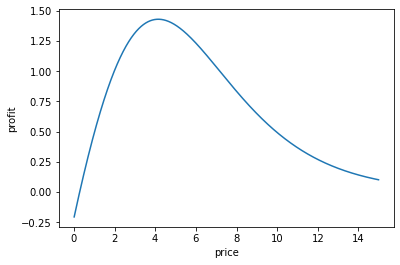

In [1057]:
sns.lineplot(data = op, x = "price", y = "profit");

In [1058]:
op.profit.max()

1.4300083712634568

In [1059]:
op.loc[op.profit == op.profit.max(),"price"]

414    4.15
Name: price, dtype: float64

In [1074]:
# optimize for product 999225339 at store 320 for next three month

si = 335
pi = 999296603

train = elasticity.loc[(elasticity.store_id == si) & (elasticity.prod_id == pi),:]

model = lr.fit(X = train.loc[:,['seasonality', 'discount', 'comp', 'prod_unit_price', 'sub']], y = train.tran_prod_sale_qty)

In [1075]:
seasonality = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"seasonality"].values[0] * model.coef_[0]
discount = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"discount"].values[0] * model.coef_[1]
comp = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"comp"].values[0] * model.coef_[2]
sub = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"sub"].values[0] * model.coef_[4]
cost = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"cost"].values[0]
maxv = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"max_sale_qty"].values[0]
cof = model.coef_[3]

In [1076]:
model.coef_

array([ 0.74308014,  0.12855602,  3.894573  , -0.60631957,  0.05418494])

In [1077]:
list = []
for i in np.arange(0.01, 15, 0.01):
    d = seasonality + discount + comp + sub + cof * i
    d = scipy.special.expit(d)
    list.append(d*i - d*cost)

In [1078]:
op = pd.DataFrame([np.arange(0.01, 15, 0.01),list]).T
op.columns = ["price","profit"]

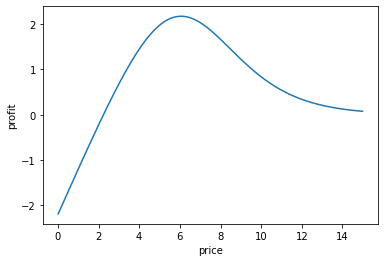

In [1079]:
sns.lineplot(data = op, x = "price", y = "profit");

In [1080]:
op.profit.max()

2.1690871046102274

In [1081]:
op.loc[op.profit == op.profit.max(),"price"]

605    6.06
Name: price, dtype: float64

In [1082]:
# optimize for product 999983304 at store 320 for next three month

si = 588
pi = 999983304

train = elasticity.loc[(elasticity.store_id == si) & (elasticity.prod_id == pi),:]

model = lr.fit(X = train.loc[:,['seasonality', 'discount', 'comp', 'prod_unit_price', 'sub']], y = train.tran_prod_sale_qty)

In [1083]:
seasonality = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"seasonality"].values[0] * model.coef_[0]
discount = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"discount"].values[0] * model.coef_[1]
comp = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"comp"].values[0] * model.coef_[2]
sub = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"sub"].values[0] * model.coef_[4]
cost = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"cost"].values[0]
maxv = tmp.loc[(tmp.store_id == si) & (tmp.prod_id == pi),"max_sale_qty"].values[0]
cof = model.coef_[3]

In [1084]:
model.coef_

array([ 0.47934953,  0.0751611 , -0.0044665 , -0.25679067,  0.0030321 ])

In [1085]:
list = []
for i in np.arange(0.01, 15, 0.01):
    d = seasonality + discount + comp + sub + cof * i
    d = scipy.special.expit(d)
    list.append(d*i - d*cost)

In [1086]:
op = pd.DataFrame([np.arange(0.01, 15, 0.01),list]).T
op.columns = ["price","profit"]

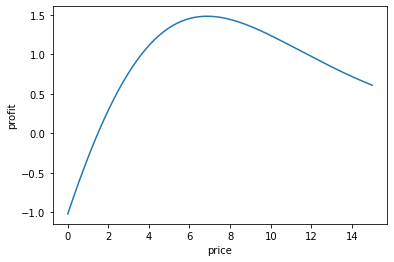

In [1087]:
sns.lineplot(data = op, x = "price", y = "profit");

In [1088]:
op.profit.max()

1.4835801189224391

In [1089]:
op.loc[op.profit == op.profit.max(),"price"]

686    6.87
Name: price, dtype: float64

# How it affect different customer segement

In [1144]:
# we analyze on the three sku & store combination we analyzed on in the last section

cluster = transaction_product.loc[transaction_product.store_id.isin([588,335,320])&transaction_product.prod_id.isin([999983304,999296603,999168803])]

In [1145]:
# we filter out the weeks that's not within the three month period we are analyzing

cluster = cluster.loc[cluster['week'].isin([13,14,15,16,17,18,19,20,21,22,23,24]),:]

In [1146]:
# Collecting the usful information

cluster = cluster.groupby(["cluster1","prod_id","store_id"]).agg({"prod_unit_price":"mean","tran_prod_sale_qty":"sum","min_price":"mean"}).reset_index()

In [1147]:
cluster

,cluster1,prod_id,store_id,prod_unit_price,tran_prod_sale_qty,min_price
0,0,999168803,320,0.665000,30.0,0.281667
1,0,999168803,588,0.665000,12.0,0.298333
2,0,999296603,320,5.323333,5.0,3.140000
3,0,999296603,335,5.490000,2.0,2.240000
4,0,999296603,588,4.990000,1.0,3.326667
5,1,999168803,588,0.665000,18.0,0.298333
6,1,999296603,335,5.990000,2.0,2.240000
7,1,999296603,588,5.056667,21.0,3.326667
8,1,999983304,588,1.990000,3.0,1.490000
9,2,999168803,335,0.665000,30.0,0.398333


In [1148]:
# get the optimal price
op = pd.DataFrame([[320,999168803,4.15,-0.40986808],[335,999296603,6.06,-0.60631957],[588,999983304,6.87,-0.25679067]], columns = ["store_id","prod_id","price","coef"])
op

,store_id,prod_id,price,coef
0,320,999168803,4.15,-0.409868
1,335,999296603,6.06,-0.606320
2,588,999983304,6.87,-0.256791


In [1149]:
cluster = cluster.merge(op, how="left", on=["store_id","prod_id"]).dropna()
cluster

,cluster1,prod_id,store_id,prod_unit_price,tran_prod_sale_qty,min_price,price,coef
0,0,999168803,320,0.665,30.0,0.281667,4.15,-0.409868
3,0,999296603,335,5.490,2.0,2.240000,6.06,-0.606320
6,1,999296603,335,5.990,2.0,2.240000,6.06,-0.606320
8,1,999983304,588,1.990,3.0,1.490000,6.87,-0.256791
11,2,999296603,335,5.990,1.0,2.240000,6.06,-0.606320
14,3,999296603,335,5.990,1.0,2.240000,6.06,-0.606320


In [1150]:
# sales quantity changes based on each cluster

cluster["new_demend"] = (cluster.price - cluster.prod_unit_price)*cluster.coef + cluster.tran_prod_sale_qty
cluster

,cluster1,prod_id,store_id,prod_unit_price,tran_prod_sale_qty,min_price,price,coef,new_demend
0,0,999168803,320,0.665,30.0,0.281667,4.15,-0.409868,28.571610
3,0,999296603,335,5.490,2.0,2.240000,6.06,-0.606320,1.654398
6,1,999296603,335,5.990,2.0,2.240000,6.06,-0.606320,1.957558
8,1,999983304,588,1.990,3.0,1.490000,6.87,-0.256791,1.746862
11,2,999296603,335,5.990,1.0,2.240000,6.06,-0.606320,0.957558
14,3,999296603,335,5.990,1.0,2.240000,6.06,-0.606320,0.957558


In [1151]:
# new revenue with the new price

cluster["revenue"] = cluster.new_demend * cluster.price
cluster

,cluster1,prod_id,store_id,prod_unit_price,tran_prod_sale_qty,min_price,price,coef,new_demend,revenue
0,0,999168803,320,0.665,30.0,0.281667,4.15,-0.409868,28.571610,118.572180
3,0,999296603,335,5.490,2.0,2.240000,6.06,-0.606320,1.654398,10.025651
6,1,999296603,335,5.990,2.0,2.240000,6.06,-0.606320,1.957558,11.862799
8,1,999983304,588,1.990,3.0,1.490000,6.87,-0.256791,1.746862,12.000939
11,2,999296603,335,5.990,1.0,2.240000,6.06,-0.606320,0.957558,5.802799
14,3,999296603,335,5.990,1.0,2.240000,6.06,-0.606320,0.957558,5.802799


In [1152]:
# new profit with the new price

cluster["profit"] = cluster.revenue -  cluster.min_price * cluster.new_demend
cluster

,cluster1,prod_id,store_id,prod_unit_price,tran_prod_sale_qty,min_price,price,coef,new_demend,revenue,profit
0,0,999168803,320,0.665,30.0,0.281667,4.15,-0.409868,28.571610,118.572180,110.524510
3,0,999296603,335,5.490,2.0,2.240000,6.06,-0.606320,1.654398,10.025651,6.319800
6,1,999296603,335,5.990,2.0,2.240000,6.06,-0.606320,1.957558,11.862799,7.477870
8,1,999983304,588,1.990,3.0,1.490000,6.87,-0.256791,1.746862,12.000939,9.398115
11,2,999296603,335,5.990,1.0,2.240000,6.06,-0.606320,0.957558,5.802799,3.657870
14,3,999296603,335,5.990,1.0,2.240000,6.06,-0.606320,0.957558,5.802799,3.657870
